# Rotor Estimation

In [1]:
import sys
sys.path.append('../build/Debug/')
from transformations import (quaternion_matrix as quaternion_to_matrix,
                             euler_matrix as euler_to_matrix, 
                             euler_from_quaternion)
import librotor_estimation as rotor_estimation

In [2]:
%pylab inline
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


## Introduction

### Dataset generation

In [3]:
r = euler_to_matrix(0.0,0.0,-np.pi/3.0)[:3,:3]
r

array([[ 0.5      ,  0.8660254,  0.       ],
       [-0.8660254,  0.5      , -0.       ],
       [-0.       ,  0.       ,  1.       ]])

In [4]:
n_points = 10
points_a = np.random.rand(n_points,3)
points_b = np.array([np.dot(r,point.reshape(3,1)).reshape(3) for point in points_a])

In [5]:
# Add noise to the rotated point cloud
sigma = 0.1
mu = 0.0
points_b_noisy = points_b + sigma * np.random.randn(n_points,3) + mu
# points_b_noisy = points_b

3D plot of the original and rotated point clouds

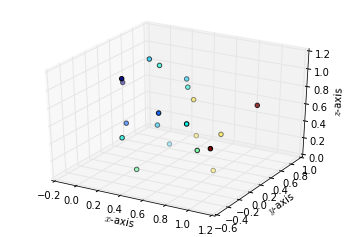

In [6]:
from mpl_toolkits.mplot3d import Axes3D
def plot_point_clouds(points_a, points_b):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    n = points_a.shape[0]
    x = points_a[:,0]
    y = points_a[:,1]
    z = points_a[:,2]
    c = x + y
    ax.scatter(x, y, z, c = c )
    x = points_b[:,0]
    y = points_b[:,1]
    z = points_b[:,2]
    ax.scatter(x, y, z, c = c)
    ax.set_xlabel('$x$-axis')
    ax.set_ylabel('$y$-axis')
    ax.set_zlabel('$z$-axis')
    
plot_point_clouds(points_a, points_b)

2D plot of the original and rotated point clouds projected onto the $xy$-plane

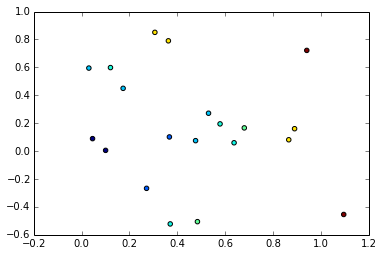

In [7]:
fig = plt.figure()
x = points_a[:,0]
y = points_a[:,1]
c = x + y
plt.scatter(x, y, c = c)
x = points_b[:,0]
y = points_b[:,1]
plt.scatter(x,y,c = c)
plt.show()

## Rotor estimation

### Estimate full rotor 
$$ R = \cos \left( \frac{\theta}{2} \right) - \sin \left( \frac{\theta}{2} \right)  B  $$

In [8]:
rotor_parameters = np.array([1.0, 0.0, 0.0, 0.0]).reshape(4,1)
re = rotor_estimation.RotorEstimation()
rotor_1 = re.run(rotor_parameters, points_a, points_b_noisy)
rotor_1

array([[ 0.83794816],
       [ 0.5447131 ],
       [-0.01511829],
       [ 0.03003259]])

### Estimate the bivector generator
$$ R = \exp \left( - \frac{\theta}{2} B \right) $$

In [9]:
bivector_parameters = np.array([0.0,0.0,0.1]).reshape(3,1)
rbe = rotor_estimation.RotorBivectorGeneratorEstimation()
rotor_2 = rbe.run(bivector_parameters, points_a, points_b_noisy)
rotor_2

array([[ 0.83794816],
       [ 0.5447131 ],
       [-0.01511829],
       [ 0.03003259]])

## Results

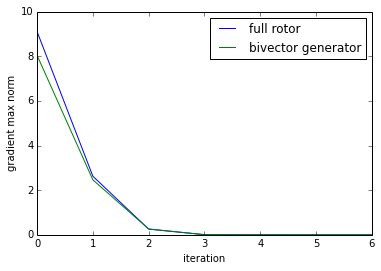

7
7


In [10]:
iterations_re = re.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_re], label='full rotor')
iterations_rbe = rbe.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_rbe],label='bivector generator')
plt.legend()
plt.xticks([iteration['iteration'] for iteration in max(iterations_rbe, iterations_re)])
plt.xlabel('iteration')
plt.ylabel('gradient max norm')
plt.show()
print(len(iterations_re))
print(len(iterations_rbe))

In [11]:
def rotor_to_quaternion(rotor):
    rotor = rotor.ravel()
    return np.array([-rotor[3], rotor[2], -rotor[1],rotor[0]])

In [12]:
r = quaternion_to_matrix(rotor_to_quaternion(rotor_1))[:3,:3]
r

array([[ 0.40611815,  0.91379076,  0.00738159],
       [-0.9119746 ,  0.40477136,  0.06680177],
       [ 0.05805498, -0.03386124,  0.99773896]])

In [13]:
points_b_estimated = np.array([np.dot(r,point.reshape(3,1)).reshape(3) for point in points_a])

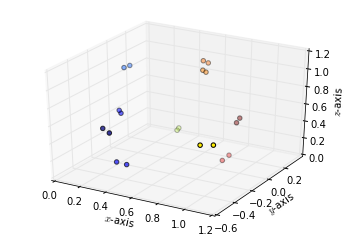

In [14]:
plot_point_clouds(points_b, points_b_estimated)

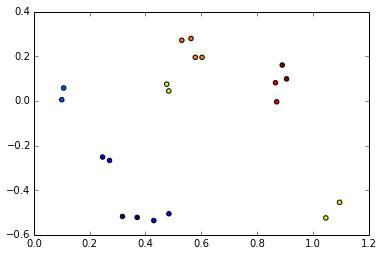

In [15]:
fig = plt.figure()
x = points_b[:,0]
y = points_b[:,1]
c = x + y
plt.scatter(x, y, c = c)
x = points_b_estimated[:,0]
y = points_b_estimated[:,1]
plt.scatter(x,y,c = c)
plt.show()